In [1]:
# a demonstration of use of the two-layered neural network classifier 
# for content classification on doc2vec docs vectors
# where softmax probabilities of the classified content against the given categories can be used as relevance rating
# towards the classified categories

# references:
# [1] https://deeplearning4j.org/word2vec.html
# [2] https://deeplearning4j.org/welldressed-recommendation-engine
# [3] https://www.tensorflow.org/get_started/tflearn
# [4] http://scikit-learn.org/stable/modules/cross_validation.html

# author Michal Stefanik  mistefan  at  redhat dot com

import numpy as np
import pandas as pd
import random

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.estimators.estimator import SKCompat

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold

# D2VWrapper is our implementation providing vectorization of the documents based on doc2vec
from doc2vec_wrapper import D2VWrapper

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
# optimization steps are reduced on TEST_MODE
TEST_MODE = False

# target categories
product_list = ["amq", "eap", "webserver", "datagrid", "fuse", "brms", "bpmsuite", "devstudio", "cdk",
                "developertoolset", "rhel", "softwarecollections", "mobileplatform", "openshift"]

In [3]:
# extended evaluation metric on selected category
def accuracy_for_category(y_expected, y_actual, label):
    label_expected = y_expected[y_expected == label]
    intersect = y_expected[np.where(y_expected == y_actual)]
    label_intersect = intersect[intersect == label]
    if len(label_expected) == 0:
        logging.warn("Accuracy of %s category evaluated on 0 samples" % label)
        return 1 if len(label_intersect) == 0 else 0
    else:
        return float(len(label_intersect)) / len(label_expected)

In [4]:
# initialize d2v_wrapper providing as well metadata about the models state
d2v_wrapper = D2VWrapper(content_categories=product_list,
                         vector_length=500)

# EITHER initialize the vocab of documents and minimize the distances of embeddings in training phase
# d2v_wrapper.init_model_vocab(drop_short_docs=10)
# d2v_wrapper.train_model(shuffle=True, epochs=1 if TEST_MODE else 100)

# OR load initialized and trained wrapper if available
d2v_wrapper.load_persisted_wrapper("trained_models/wrapper/10epoch_train_stem")

2017-04-12 12:21:00,133 : INFO : Loading serialized wrapper model from: trained_models/wrapper/10epoch_train_stem
2017-04-12 12:21:00,133 : INFO : Loading docs objects
2017-04-12 12:21:07,430 : INFO : Loading docs vectors
2017-04-12 12:21:27,024 : INFO : Loading trained Doc2Vec model
2017-04-12 12:21:27,025 : INFO : loading Doc2Vec object from trained_models/wrapper/10epoch_train_stemdoc2vec.mod
2017-04-12 12:21:27,294 : INFO : loading docvecs recursively from trained_models/wrapper/10epoch_train_stemdoc2vec.mod.docvecs.* with mmap=None
2017-04-12 12:21:27,294 : INFO : loading doctag_syn0 from trained_models/wrapper/10epoch_train_stemdoc2vec.mod.docvecs.doctag_syn0.npy with mmap=None
2017-04-12 12:21:27,439 : INFO : loading syn1neg from trained_models/wrapper/10epoch_train_stemdoc2vec.mod.syn1neg.npy with mmap=None
2017-04-12 12:21:27,548 : INFO : loading syn0 from trained_models/wrapper/10epoch_train_stemdoc2vec.mod.syn0.npy with mmap=None
2017-04-12 12:21:27,661 : INFO : setting igno

In [5]:
# transform the doc data set into a vector set of the given vector_length
doc_vectors_labeled = d2v_wrapper.infer_content_vectors()
doc_vectors = doc_vectors_labeled.iloc[:, :-1]
doc_labels = doc_vectors_labeled.iloc[:, -1]

2017-04-12 12:21:27,723 : INFO : Returning already inferred doc vectors


In [6]:
doc_labels.describe()

count     43395
unique       14
top         eap
freq      18355
Name: y, dtype: object

In [7]:
# limit the content to specific categories
# limit_prod_list = ["webserver", "datagrid", "fuse", "brms"]
# doc_vectors = doc_vectors[doc_labels.isin(limit_prod_list)]
# doc_labels = doc_labels[doc_labels.isin(limit_prod_list)]
# doc_vectors.describe()

In [22]:
# classifier training and eval:
from sklearn.linear_model import LogisticRegression

# results collection
accuracies = []
cat_accuracies = pd.DataFrame(columns=d2v_wrapper.content_categories)
logits = pd.DataFrame(columns=["actual_prob", "expected_prob", "actual_class", "expected_class"])
wrong_docs_ids = pd.Series()

# evaluation on CV split persisting the categories respective size on each split
strat_kfold = StratifiedKFold(n_splits=2 if TEST_MODE else 5, shuffle=True)

for train_doc_indices, test_doc_indices in strat_kfold.split(doc_vectors, doc_labels):

    random.shuffle(train_doc_indices)
    random.shuffle(test_doc_indices)
    
    # training
    logging.info("Fitting classifier")
    log_reg_classifier = LogisticRegression(C=0.3, solver="sag", multi_class='ovr', n_jobs=8, max_iter=1000)
    log_reg_classifier.fit(doc_vectors.iloc[train_doc_indices], doc_labels.iloc[train_doc_indices])
    
    # testing
    logging.info("Predicting")
    y_expected = doc_labels.iloc[test_doc_indices].values
    y_actual = log_reg_classifier.predict(doc_vectors.iloc[test_doc_indices])
    
    # evaluation:
    # logits
    logging.info("Probs collection")
    class_probs = log_reg_classifier.predict_proba(doc_vectors.iloc[test_doc_indices])
    class_ordered = list(log_reg_classifier.classes_)
    
    class_actual_index = pd.Series(y_actual).apply(lambda cat_label: class_ordered.index(cat_label))
    actual_prob = class_probs[np.arange(len(class_actual_index)),(class_actual_index)]
    
    class_expected_index = pd.Series(y_expected).apply(lambda cat_label: class_ordered.index(cat_label))
    expected_prob = class_probs[np.arange(len(class_actual_index)),(class_expected_index)]
    
    new_logits = pd.DataFrame()
    new_logits["doc_id"] = test_doc_indices
    new_logits["actual_prob"] = actual_prob
    new_logits["expected_prob"] = expected_prob
    new_logits["actual_class"] = y_actual
    new_logits["expected_class"] = y_expected
    logits = logits.append(new_logits)
    
    # accuracy
    logging.info("Split results:")
    split_accuracy = accuracy_score(y_expected, y_actual)
    logging.info("Run accuracy: %s" % split_accuracy)
    accuracies.append(split_accuracy)
    split_cat_accuracies = map(lambda cat: accuracy_for_category(y_expected, y_actual, cat),
                               d2v_wrapper.content_categories)
    logging.info("Cat accuracies:\n%s" % split_cat_accuracies)
    cat_accuracies = cat_accuracies.append(
        pd.DataFrame(data=[split_cat_accuracies], columns=d2v_wrapper.content_categories))
    
    # misclassified docs collection
    wrong_docs_ids = wrong_docs_ids.append(pd.Series(test_doc_indices[y_actual != y_expected]))

2017-04-12 14:02:16,346 : INFO : Fitting classifier
2017-04-12 14:03:18,574 : INFO : Predicting
2017-04-12 14:03:18,685 : INFO : Probs collection
2017-04-12 14:03:18,809 : INFO : Split results:
2017-04-12 14:03:18,815 : INFO : Run accuracy: 0.842238599724
2017-04-12 14:03:18,821 : INFO : Cat accuracies:
[0.248, 0.93435031326614, 0.32044198895027626, 0.2807017543859649, 0.8581610833927299, 0.42735042735042733, 0.49230769230769234, 0.7723823975720789, 0.07142857142857142, 0.0, 0.9306930693069307, 0.0, 0.42857142857142855, 0.7905824039653035]
2017-04-12 14:03:18,842 : INFO : Fitting classifier
2017-04-12 14:04:21,072 : INFO : Predicting
2017-04-12 14:04:21,221 : INFO : Probs collection
2017-04-12 14:04:21,388 : INFO : Split results:
2017-04-12 14:04:21,394 : INFO : Run accuracy: 0.834235687133
2017-04-12 14:04:21,401 : INFO : Cat accuracies:
[0.224, 0.9289022064832471, 0.2983425414364641, 0.2982456140350877, 0.849607982893799, 0.4334763948497854, 0.5076923076923077, 0.729483282674772, 0.0

In [23]:
logging.info("split accuracies: %s" % accuracies)
logging.info("mean accuracy: %s" % np.mean(accuracies))
logging.info("categories accuracies: \n%s" % cat_accuracies)
logging.info("categories accuracies mean: \n%s" % cat_accuracies.mean())
logging.info("done")

2017-04-12 14:07:21,609 : INFO : split accuracies: [0.84223859972362969, 0.83423568713281882, 0.82461396635169393, 0.83531174369021555, 0.83561959654178675]
2017-04-12 14:07:21,610 : INFO : mean accuracy: 0.834403918688
2017-04-12 14:07:21,618 : INFO : categories accuracies: 
     amq       eap  webserver  datagrid      fuse      brms  bpmsuite  \
0  0.248  0.934350   0.320442  0.280702  0.858161  0.427350  0.492308   
0  0.224  0.928902   0.298343  0.298246  0.849608  0.433476  0.507692   
0  0.264  0.922092   0.292818  0.368421  0.848182  0.407725  0.400000   
0  0.304  0.930537   0.314917  0.473684  0.864576  0.416309  0.474227   
0  0.232  0.930264   0.261111  0.333333  0.848895  0.420601  0.458763   

   devstudio       cdk  developertoolset      rhel  softwarecollections  \
0   0.772382  0.071429               0.0  0.930693                  0.0   
0   0.729483  0.071429               0.0  0.933740                  0.0   
0   0.737082  0.142857               0.0  0.905488         

In [24]:
# accuracies of categories together with their size

labels_size = pd.DataFrame()
labels_size["label"] = doc_labels.unique()
labels_size["accuracy"] = cat_accuracies.mean().values
labels_size["size"] = [len(doc_labels[doc_labels == cat]) for cat in labels_size["label"]]
labels_size = labels_size.sort_values(by=["size"])

labels_size

,label,accuracy,size
11,softwarecollections,0.000000,5
9,developertoolset,0.000000,12
8,cdk,0.085714,69
12,mobileplatform,0.345714,101
3,datagrid,0.350877,285
0,amq,0.254400,625
2,webserver,0.297526,904
6,bpmsuite,0.466598,973
5,brms,0.421092,1166
7,devstudio,0.750525,3291


In [25]:
# computed actual_prob probabilities might be used as ranking system of the relevance of documents towards categories
logits["doc_id"] = logits["doc_id"].apply(lambda x: int(x))
logits = logits.set_index("doc_id")
logits.head(25)

,actual_class,actual_prob,expected_class,expected_prob
doc_id,,,,
25374,fuse,0.986000,fuse,0.986000
15970,eap,0.933202,eap,0.933202
14082,eap,0.969213,eap,0.969213
33580,rhel,0.934941,rhel,0.934941
31289,devstudio,0.828634,devstudio,0.828634
42130,eap,0.479372,openshift,0.300380
41939,openshift,0.916762,openshift,0.916762
5474,eap,0.991805,eap,0.991805
38302,rhel,0.930929,rhel,0.930929


In [26]:
biggest_cats = labels_size["label"][-6:]
biggest_cats_df = logits[logits["expected_class"].isin(biggest_cats)]
biggest_cats_df["expected_class"].unique()

array(['fuse', 'eap', 'rhel', 'devstudio', 'openshift', 'brms'], dtype=object)

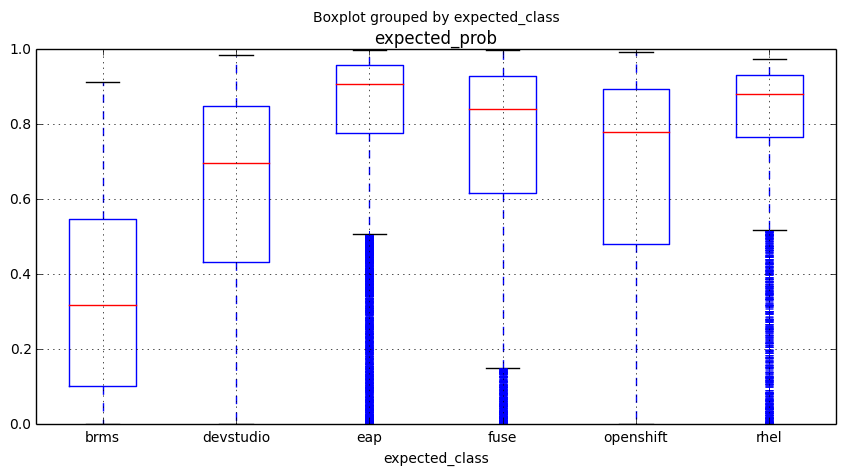

In [27]:
# boxplot visualization of the scores of documents against its own category (biggest 6 classes)
# the higher the better
# we see that it goes much better for bigger categories

# boxplot: 50% of data in box, 90% in dashed intervals
%matplotlib inline
import matplotlib.pyplot as plt

join_label_size = labels_size
join_label_size["expected_class"] = join_label_size["label"]

biggest_cats_df.boxplot("expected_prob", by="expected_class", figsize=(10,5))

In [28]:
# incorrect classification characteristics
wrong_docs_ids = pd.Series(logits[logits["expected_class"] != logits["actual_class"]].index)

wrong_docs_wordlist = wrong_docs_ids.apply(lambda doc_id: d2v_wrapper.get_doc_content(int(doc_id), word_split=True))
wrong_docs_len = wrong_docs_wordlist.apply(lambda doc: len(doc))
wrong_docs_len.describe()

count     7186.000000
mean       132.662399
std        930.570728
min         10.000000
25%         19.000000
50%         30.000000
75%         66.000000
max      72938.000000
Name: doc_id, dtype: float64

In [29]:
# correct classification characteristics
all_indices = pd.Series(np.arange(len(doc_vectors)))
correct_docs =  all_indices[~all_indices.isin(wrong_docs_ids)]
# data need to be indexed incrementally for later plotting
correct_docs.index=np.arange(len(correct_docs))
correct_docs_wordlist = correct_docs.apply(lambda doc_id: d2v_wrapper.get_doc_content(doc_id, word_split=True))
correct_docs_len = correct_docs_wordlist.apply(lambda doc: len(doc))

correct_docs_len.describe()

count    36209.000000
mean       129.604353
std        469.996794
min         10.000000
25%         24.000000
50%         38.000000
75%         98.000000
max      55969.000000
dtype: float64

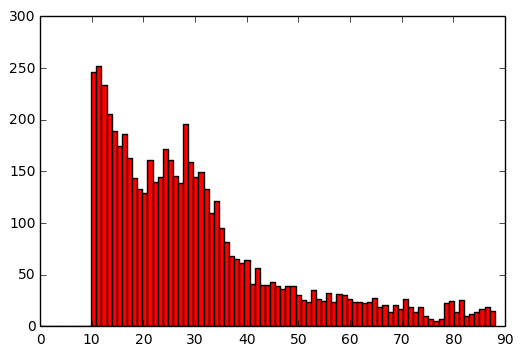

In [30]:
# missclassified docs length distribution
bordering_q = 0.8
bordering_q_value = int(wrong_docs_len.quantile(q=bordering_q))
plt.hist(wrong_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="r")
plt.show()

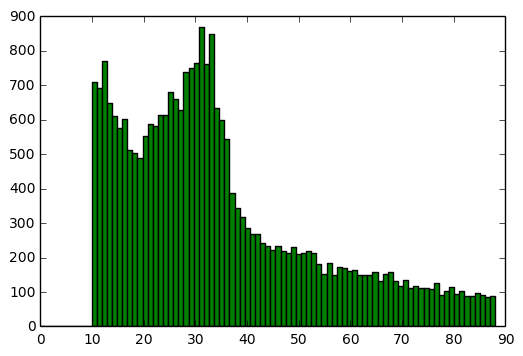

In [31]:
# correctly classified length distribution
plt.hist(correct_docs_len, bins=bordering_q_value+1, range=(0, bordering_q_value), color="g")
plt.show()

<Container object of 88 artists>

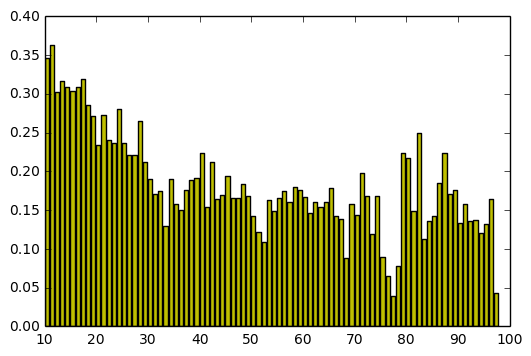

In [32]:
# distribution of correctly/incorrectly classified ratio by docs length
doc_len_error = (wrong_docs_len.value_counts() / correct_docs_len.value_counts())
ploted_doc_len_error = doc_len_error[:bordering_q_value]

plt.bar(ploted_doc_len_error.index, ploted_doc_len_error, color="y")

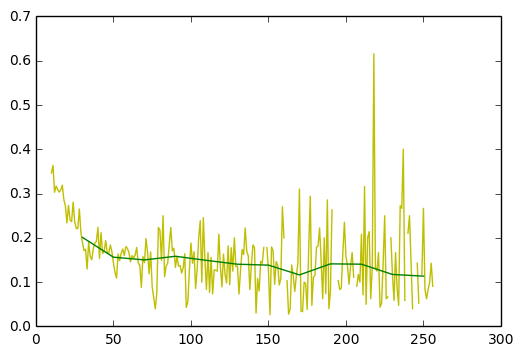

In [39]:
error_plot_border = 250
error_ploted = doc_len_error[:error_plot_border]
plt.plot(error_ploted.index, error_ploted, color="y")
mean_range = 20

mean_plot_ids = range(mean_range, error_plot_border+mean_range, mean_range)
mean_plot_vals = map(lambda mean_id: error_ploted.iloc[mean_id-5-mean_range: mean_id+5-mean_range].mean(), mean_plot_ids)
mean_plot = pd.Series(mean_plot_vals)
mean_plot.index = np.array(mean_plot_ids)-mean_range/2
plt.plot(mean_plot.index , mean_plot, color="g")

In [34]:
# docs get associated with its content
logits["content_len"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                         len(d2v_wrapper.get_doc_content(int(doc_id), word_split=True)))
logits["content"] = pd.Series(logits.index).apply(lambda doc_id: 
                                                     d2v_wrapper.get_doc_content(int(doc_id), word_split=False)[:100])
logits.head(10)

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
25374,fuse,0.986000,fuse,0.986000,49,jboss jbm msg tabl store jm messag messag cont...
15970,eap,0.933202,eap,0.933202,865,try run jboss jdk eclips follow except java la...
14082,eap,0.969213,eap,0.969213,72,number script configur server thing applic ad ...
33580,rhel,0.934941,rhel,0.934941,51,jee applic sfsb set specif timeout.need easi a...
31289,devstudio,0.828634,devstudio,0.828634,28,openstack comput central compon provid virtual...
42130,eap,0.479372,openshift,0.300380,12,caus error messag java ioexcept transport conn...
41939,openshift,0.916762,openshift,0.916762,20,prevent context deploi access.mod cluster node...
5474,eap,0.991805,eap,0.991805,23,rexml parser rubi patchlevel patchlevel allow ...
38302,rhel,0.930929,rhel,0.930929,35,product version level updat visibl red hat ent...


In [52]:
# misclassified docs with its content 
logits[logits["actual_class"] != logits["expected_class"]][:20]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
42130,eap,0.479372,openshift,0.300380,12,caus error messag java ioexcept transport conn...
193,fuse,0.396881,amq,0.352965,61,jboss support ejb rmi try access ejb avail jbo...
24469,eap,0.841630,fuse,0.083891,22,jbadmcon http issu jboss org brows jbadmcon ne...
15813,openshift,0.802478,eap,0.160075,25,red hat enterpris linux releas end march month...
29124,eap,0.853645,bpmsuite,0.004389,32,amqp type decod apach qpid earlier allow remot...
147,eap,0.741702,amq,0.002021,13,restor snapshot root contain contain creat rhc...
27200,eap,0.575238,brms,0.359489,21,evalu jbpm workflow requir.advantag form model...
40437,eap,0.500310,openshift,0.403931,249,background run jee applic jboss.content reposi...
19759,eap,0.746564,webserver,0.185649,183,attempt us pkc keystor manag interfac pkc keys...


In [53]:
# correctly classified docs with its content
logits[logits["actual_class"] == logits["expected_class"]][:20]

,actual_class,actual_prob,expected_class,expected_prob,content_len,content
doc_id,,,,,,
25374,fuse,0.986000,fuse,0.986000,49,jboss jbm msg tabl store jm messag messag cont...
15970,eap,0.933202,eap,0.933202,865,try run jboss jdk eclips follow except java la...
14082,eap,0.969213,eap,0.969213,72,number script configur server thing applic ad ...
33580,rhel,0.934941,rhel,0.934941,51,jee applic sfsb set specif timeout.need easi a...
31289,devstudio,0.828634,devstudio,0.828634,28,openstack comput central compon provid virtual...
41939,openshift,0.916762,openshift,0.916762,20,prevent context deploi access.mod cluster node...
5474,eap,0.991805,eap,0.991805,23,rexml parser rubi patchlevel patchlevel allow ...
38302,rhel,0.930929,rhel,0.930929,35,product version level updat visibl red hat ent...
41500,openshift,0.933784,openshift,0.933784,596,try implement rest webservic jersei.jboss fina...
